# Mouse Cerebellum (Slide-seqV2)

In [70]:
import sys
sys.path.append('E:/Anaconda/envs/SpaVAEW/Lib/site-packages/')
import glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

import SpaGTL

## Data loading and preprocessing

The dataset(including Slide-seqV2 data, marker genes list) is available at Single Cell Portal (https://singlecell.broadinstitute.org/single_cell/study/SCP948).
We load the dataset and perform preprocessing log transformation.

In [71]:
Slide_seq=sc.read_h5ad('E:/data/Slide_seq_brain/data/Cerebellum.h5ad')
Gene=pd.read_csv('E:/data/Slide_seq_brain/Gene.csv',index_col=0)['x']
Annotation=pd.read_csv('E:/data/Slide_seq_brain/annotation.csv',index_col=0)['first_type']
Slide_seq=Slide_seq[Annotation.index,Gene]
Slide_seq.obs['cell_type']=Annotation

C:\Users\123\AppData\Local\Temp\ipykernel_7116\4010773200.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Slide_seq.obs['cell_type']=Annotation


In [108]:
Slide_seq.obsm['spatial']=Slide_seq.obsm['spatial'].values

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


<AxesSubplot: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>

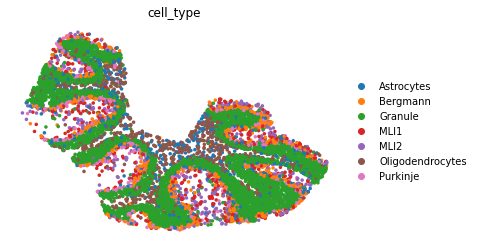

In [109]:
sc.pl.embedding(
    Slide_seq,
    colorbar_loc=None,
    frameon=False,
    basis='spatial',
    color=['cell_type'],
    size=50,
    show=False
)

## Spatial reconstruction

We perform spatial reconstruction to aggregate expression from spatial neighbors.

In [72]:
SpaGTL.spatial_reconstruction(Slide_seq, alpha=8)

## Graph Transfer Learning

We perform graph transfer learning on the preprocessed data.

In [73]:
params_dict = np.load('E:/江小白/data/params_dict.npy', allow_pickle=True).item()
intersection = [value for value in params_dict['genes'] if value in Slide_seq.var_names]
len(intersection)
adata=Slide_seq[:,intersection]
SpaGTL.run_SpaGTL(adata, n_epochs=1000,params_dict=params_dict)

100%|█████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.28it/s, loss: 6.149e+03]
E:\Anaconda/envs/SpaVAEW/Lib/site-packages\SpaGTL\_SpaGTL.py:156: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
E:\Anaconda\envs\sparcl\lib\site-packages\anndata\_core\anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## Regulon inference and aucell

We perform regulon inference using gene relation matrix.

In [74]:
from yaml import Loader, Dumper
import glob
MOTIF_ANNOTATIONS_FNAME='E:/data/CisTarget/motifs-v9-nr.mgi-m0.001-o0.0.tbl'
tf_names=np.array((pd.read_table('E:/data/CisTarget/mm_mgi_tfs.txt',header=None).iloc[:,0]))
DATABASES_GLOB='E:/data/CisTarget/mm9-*.mc9nr.feather'
db_fnames = glob.glob(DATABASES_GLOB)

In [75]:
SpaGTL.regulons(adata, tf_names, MOTIF_ANNOTATIONS_FNAME, db_fnames, neighbors_var_key='QK')


2024-07-12 20:12:46,550 - pyscenic.utils - INFO - Creating modules.


Create regulons from a dataframe of enriched features.
Additional columns saved: []


We perform aucell to compute the activity of each regulon on each spot.

In [76]:
adata.X=adata.layers['x4']
SpaGTL.aucell(adata, normalize=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 94/94 [00:03<00:00, 29.93it/s]


In [90]:
adata_aucell = sc.AnnData(adata.obsm['aucell'])
adata_aucell.obs = adata.obs.copy()
adata_aucell.obsm['spatial'] = adata.obsm['spatial'].values

## Finding differentially activity regulons

We find the differentially activity regulons across identified cell types and show the domains and their differentially activity regulons patterns in spatial coordinates.

In [91]:
sc.tl.rank_genes_groups(adata_aucell, groupby='cell_type', method='t-test_overestim_var')

In [92]:
pd.DataFrame(adata_aucell.uns['rank_genes_groups']['names']).iloc[:10,:]

,Astrocytes,Bergmann,Granule,MLI1,MLI2,Oligodendrocytes,Purkinje
0,Foxo1(+),Sox2(+),Etv1(+),Esrrg(+),Esrrg(+),Sox10(+),Bcl11a(+)
1,Elf1(+),Sox9(+),Foxo3(+),Mafb(+),Mafb(+),Olig2(+),Lmo2(+)
2,Sox9(+),Elk3(+),Klf6(+),Msx1(+),Nfe2l1(+),Olig1(+),Mef2c(+)
3,Arnt2(+),Pparg(+),Cux1(+),Prdx5(+),Prdx5(+),Sox8(+),Nr2f2(+)
4,Sox2(+),Etv4(+),Klf9(+),Lmo2(+),Msx1(+),Creb5(+),Ikzf2(+)
5,Tcf7l1(+),Sox18(+),Rbpj(+),Nfe2l1(+),Ets1(+),Zfhx3(+),Foxj1(+)
6,Etv4(+),Etv5(+),Meis1(+),Foxj1(+),Arnt2(+),Arnt2(+),Ets1(+)
7,Foxj1(+),Msx1(+),Ep300(+),Arnt2(+),Etv5(+),Elf2(+),Foxp2(+)
8,Elk3(+),Foxj1(+),Rcor1(+),Ets1(+),Lmo2(+),Klf2(+),Prdx5(+)
9,Sox8(+),Nfe2l2(+),Maf(+),Etv5(+),Klf12(+),Rorb(+),Msx1(+)


E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<AxesSubplot: title={'center': 'Sox10(+)'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>]

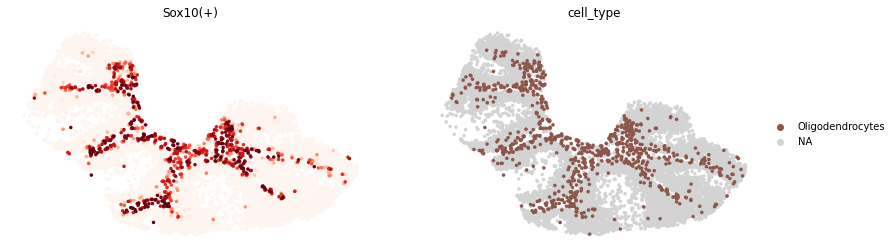

In [97]:
sc.pl.embedding(
    adata_aucell,
    colorbar_loc=None,
    frameon=False,
    basis='spatial',
    color=['Sox10(+)','cell_type'],
    size=50,
    groups='Oligodendrocytes',
    color_map='Reds',
    vmax='p99',
    vmin='p90',
    show=False
)

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<AxesSubplot: title={'center': 'Cux1(+)'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>]

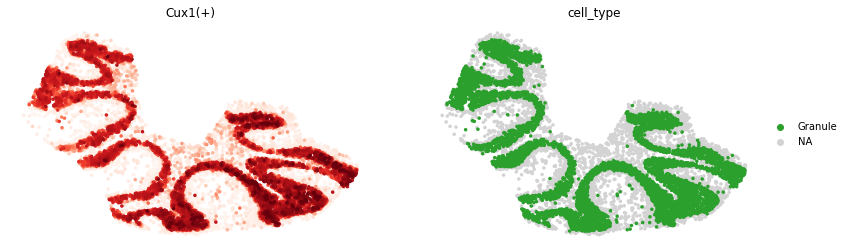

In [101]:
sc.pl.embedding(
    adata_aucell,
    colorbar_loc=None,
    frameon=False,
    basis='spatial',
    color=['Cux1(+)','cell_type'],
    size=50,
    groups='Granule',
    color_map='Reds',
    vmax='p99',
    show=False
)

E:\Anaconda\envs\sparcl\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


[<AxesSubplot: title={'center': 'Bcl11a(+)'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot: title={'center': 'cell_type'}, xlabel='spatial1', ylabel='spatial2'>]

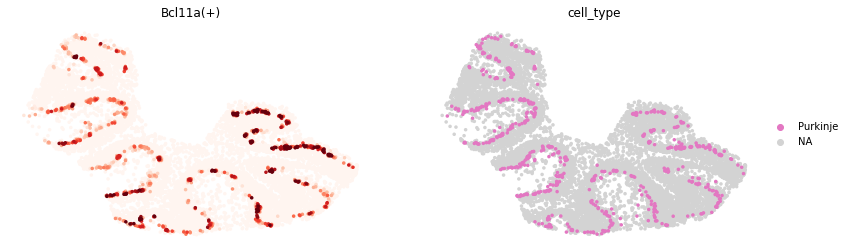

In [106]:
sc.pl.embedding(
    adata_aucell,
    colorbar_loc=None,
    frameon=False,
    basis='spatial',
    color=['Bcl11a(+)','cell_type'],
    size=50,
    groups='Purkinje',
    color_map='Reds',
    vmax='p99',
    vmin='p90',
    show=False
)